# Set Variables

In [1]:
# -------- dataset
# software_name = "camel"
# software_name = "cloudstack"
software_name = "geode"
# software_name = "hbase"

# -------- bad smell
# bad_smell = "CC" # Cyclomatic Complexity
bad_smell = "DE" # Design
# bad_smell = "NC" # Npath Complexity

# --------
my_keyword_Based = True
# my_keyword_Based = False
my_docMaxLen = 100 if my_keyword_Based else None

# Google Colab

In [2]:
sub_folder = software_name + "_" + bad_smell

In [3]:
if software_name == "camel":
    dataset_file_name = "camel_DE - v.02"
    
elif software_name == "cloudstack":
    dataset_file_name = "cloudstack_DE - v.01"
    
elif software_name == "geode":
    dataset_file_name = "geode_DE - v.01"
    
else:
    dataset_file_name = "hbase_DE - v.01"

In [4]:
tempPre = "E:/darsy/00/02- arshad/10- paper code/"

In [5]:
tempData =   "00- My Data/Datasets/Direct Method/"
tempOutput = "01- Jupyter Notebook/Direct Method/00. Output/"

pre_path_data   = tempPre + tempData   + software_name + "/" + sub_folder + "/"
pre_path_output = tempPre + tempOutput + software_name + "/" + sub_folder + "/" + dataset_file_name + "/"

# Libs

In [6]:
import string
import re
import json
import os.path
import copy
import math
import time
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.text import TextCollection

In [7]:
# import nltk
# nltk.download("stopwords")

In [8]:
!python -V
import matplotlib
print(matplotlib.__version__)

Python 3.7.11
3.5.0


# Config

In [9]:
mypaths = {
    "dataset":        pre_path_data   + dataset_file_name + ".csv",
    "w2v": {
        # "pre_trained_model":  pre_path_data   + "w2vGoogle.bin",
        "pre_trained_model":  tempPre + tempData + "w2vGoogle.bin"
    }, 
    "tfidf": {
        "output_vec":         pre_path_output + "tfidf-vector-v01.json"
    },
}

preprocessing_params = {
    "columns_name":   ["text", "bug_class_2"],
    "columns_dtype" : {0: "str", 1: "int64"},
    "bug_classes": [0, 1], 
    "num_bug_classes": 2,
    "keyword_Based": my_keyword_Based,
    "docMaxLen": my_docMaxLen,
}

# I. Compose

In [10]:
class Rows(object):
    def __init__(self, columns_name, bug_classes):
        self.columns_name = columns_name
        self.bug_classes = bug_classes
    
    
    def __call__(self, df):
        # 1. Set cells to None that have just white spaces
        df = df.apply(self.white_spaces_to_None_, axis=1)
        
        # 2. Delete rows that have NaN values in each of its columns
        df.dropna(axis=0, how="any", subset=self.columns_name, inplace=True)
        
        # 3. Delete rows with class value other than [0, 1]
        indexNames = df[~df["bug_class_2"].isin(self.bug_classes)].index
        df.drop(indexNames, axis=0, inplace=True)
        
        return df
    
    
    # set columns that just have white spaces to None
    def white_spaces_to_None_(self, row):
        for i in self.columns_name:
            if row[i] and len(str(row[i]).strip()) == 0:
                row[i] = None
        return row

# II. Read Files

In [11]:
df_main = pd.read_csv(
    mypaths["dataset"], 
    names=preprocessing_params["columns_name"], 
    dtype=preprocessing_params["columns_dtype"],
    header=None, 
    skip_blank_lines=True
)

composed_pre = transforms.Compose([
    Rows(
        preprocessing_params["columns_name"], 
        preprocessing_params["bug_classes"]
    )
])

df_main = composed_pre(df_main)

In [12]:
texts = df_main["text"].tolist()

In [13]:
print(len(df_main))

3608


# III. ClassDistribution
In order to see whether dataset is `imbalance` or not.

In [14]:
class ClassDistribution():
    def __init__(self, class_distributions):
        self.num_samples = sum(class_distributions.values())
        self.class_distributions = class_distributions # {"class0": num0, "class1": num1, ...}
        self.ratios = {} # {"1/0": ratio1, "1/2": ratio2, ...}
        self.percentage = {} # {"class0": perc0, "class1": perc1, ...}
    
    
    def calc_ratios(self):
        mydata_sorted = [(key, value) for key, value in sorted(self.class_distributions.items(), 
                                                               key=lambda item: item[1], reverse=True)]
        num_classes = len(self.class_distributions)
        for i in range(num_classes - 1):
            for j in range(i + 1, num_classes):
                tempKey1 = mydata_sorted[i][0]
                tempKey2 = mydata_sorted[j][0]
                mykey = tempKey1 + "/" + tempKey2
                
                tempValue1 = mydata_sorted[i][1]
                tempValue2 = mydata_sorted[j][1]
                self.ratios[mykey] = tempValue1 / tempValue2
    
    def calc_percentage(self):
        for key, value in self.class_distributions.items():
            tempPerc = (value * 100) / self.num_samples
            tempPerc = round(tempPerc)
            tempPerc = str(tempPerc) + "%"
            self.percentage[key] = tempPerc
    
    
    def plot_data(self, dataName):
        myclasses = list(self.class_distributions.keys())
        num_bugreports_perclass = list(self.class_distributions.values())

        fig, ax = plt.subplots(1, figsize=(5, 3))
        
        ax.bar(myclasses, num_bugreports_perclass, color ="maroon", label="Bug Reports", width=0.4)
        ax.set_xlabel("classes")
        ax.set_ylabel("Number of bug reports")
        ax.legend()
        ax.set_title("Number of bug reports PER classes [{}]".format(dataName))

        fig.tight_layout()

## obj

ratios     :  {'0/1': 3.6918075422626786}
percentages:  {'0': '79%', '1': '21%'}


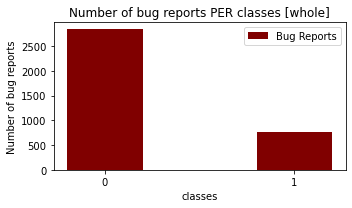

In [15]:
cds = {} # {"train": {"class0": num0, "class1": num1, ...}, "validation": {...}, ...}
# calculate class distribution for whole dataset
temp = df_main.groupby("bug_class_2").size()
cd_whole = temp.to_dict()
cd_whole = {str(key): value for key, value in cd_whole.items()}
cds["whole"] = cd_whole

# plot class distribution for whole dataset
wholeCD = ClassDistribution(cd_whole)
wholeCD.calc_ratios()
print("ratios     : ", wholeCD.ratios)
wholeCD.calc_percentage()
print("percentages: ", wholeCD.percentage)
wholeCD.plot_data("whole")

# I. Preprocessing

In [16]:
class Preprocessing():
    
    docMaxLen = 0 # max keywords allowed
    w2vDic = {} # dic : {"w1": [0.1, 0.2, ...], "w2": [0.1, 0.3, ...], ...}
    paddingVector = np.zeros(300, dtype="float32")
    bugRepTokens = [] # [[w1, w2, w3, ...], [w1, w2, ...], ...]
    docMaxTokenNo_org = 0
    docMaxTokenNo = 0 # max doc len after vectorization
    vector_tfidf = [] # array of dictinaries: [{"w1": 0.1, "w2": 0.3, ...}, {}, ...]
    vector_em = [] # array of matrix : [ [w1Vector, w2Vector], [], ...] 
    
    
    def __init__(self, docMaxLen):
        self.docMaxLen = docMaxLen
    
    
    def tokenize(self, texts):
        stop_words = set(stopwords.words("english"))
        excludedTokens = {"http", "url", "https"}
        self.my_deleted_bug = {}
        # self.df.columns[0] : "description"
        for i, doc in enumerate(texts):
            thisTokens = []
            doc = doc.lower()
            for token in WordPunctTokenizer().tokenize(doc):
                if (token in string.punctuation or token in stop_words or token in excludedTokens or 
                    (not re.findall("\w", token)) or re.findall("\A[0-9]", token)):
                    continue
                thisTokens.append(token)
                self.w2vDic[token] = self.paddingVector
            if len(thisTokens) <= 20000:
                self.bugRepTokens.append(thisTokens)
            else:
                self.my_deleted_bug[i] = len(thisTokens)
            if (len(thisTokens) > self.docMaxTokenNo_org):
                self.docMaxTokenNo_org = len(thisTokens)
    
    
    # tfidf of corpuses words
    def load_tfidf(self, tfidf_path):
        with open(tfidf_path, "r") as filehandle:
            self.vector_tfidf = json.load(filehandle)
    
    
    def loadW2V(self, w2vpath):
         with open(w2vpath, "rb") as f:
            header = f.readline()
            model_vocab_size, model_vector_size = map(int, header.split())
            binary_len = np.dtype("float32").itemsize * model_vector_size
            
            for line_no in range(model_vocab_size):
                word = []
                while True:
                    ch = f.read(1)
                    if ch == b" ":
                        break
                    if ch == b"":
                        raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
                    if ch != b"\n":
                        word.append(ch)
                word = b"".join(word).decode("utf-8")
                if (word in self.w2vDic.keys()):
                    self.w2vDic[word] = np.frombuffer(f.read(binary_len), dtype="float32")
                else:
                    f.seek(binary_len, 1)
    
    
    def vectorize_w2V (self, keywordBased=False):
        tempVec = []
        x = slice(0, self.docMaxLen)
        if keywordBased:
            print("keywordBased")
            for doc_tokens, doc_tfidf in zip(self.bugRepTokens, self.vector_tfidf):
                # docKeywords = [m for m in doc_tfidf.keys()][x]
                docKeywords = list(doc_tfidf.keys())[x]
                docAbs = self.getDocAbsrtract_(doc_tokens, docKeywords)
                tempVec = [self.w2vDic[term] for term in docAbs]
                self.vector_em.append(tempVec)
                if (len(tempVec) > self.docMaxTokenNo):
                    self.docMaxTokenNo = len(tempVec)
        else:
            print("NO keywordbased")
            for doc_tokens in self.bugRepTokens:
                tempVec = [self.w2vDic[term] for term in doc_tokens]
                self.vector_em.append(tempVec)
                if (len(tempVec) > self.docMaxTokenNo):
                    self.docMaxTokenNo = len(tempVec)
    
    
    def getDocAbsrtract_(self, doc_tok, docKeywords):
        return [t for t in doc_tok if t in docKeywords]
    
    
    def padding(self):
        for doc in self.vector_em:
            if (len(doc) < self.docMaxTokenNo):
                doc.extend([self.paddingVector] * (self.docMaxTokenNo - len(doc)))
    
    
    def freeMem(self):
        self.w2vDic = {}
        self.bugRepTokens = []
        self.vector_tfidf = []
        self.vector_em = []

## obj

In [17]:
ds = Preprocessing(preprocessing_params["docMaxLen"])
ds.tokenize(texts)
ds.load_tfidf(mypaths["tfidf"]["output_vec"])

# --- vectorize: w2v (keywordbased or no)
print("loadW2V")
ds.loadW2V(mypaths["w2v"]["pre_trained_model"])

print("vectorize_w2V")
ds.vectorize_w2V(preprocessing_params["keyword_Based"])

ds.padding()

loadW2V
vectorize_w2V
keywordBased


In [18]:
print("Max sentence length org: ", ds.docMaxTokenNo_org)
print("Max sentence length:     ", ds.docMaxTokenNo)
print("ds.df vocabulary: ", len(ds.w2vDic))
print(len(ds.vector_em))
print(len(ds.vector_em[0]))
print(len(ds.bugRepTokens))

Max sentence length org:  160706
Max sentence length:      10883
ds.df vocabulary:  19299
3606
10883
3606


In [19]:
print(len(ds.my_deleted_bug))

2


In [20]:
print(ds.my_deleted_bug)

{2671: 25257, 2831: 160706}
